# Implementación propia

Este implemanteción es un ejercicio desarrollo propio para entender la implementación completa desde cero de una NN profunda

## Metodología para construir una NN
1. Definir la estructura de la NN
   * Número de unidades de entrada
   * Número de unidades ocultas, etc
2. Inicializar los parámetros del modelo
3. Lopp
   * Implementar fordware propagation
   * Calcular la perdida (loss)
   * Implementar backware propagation para obtener los gradientes
   * Actualizar los parámetros (gradient descent)

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import datetime 
from IPython.display import display

import copy

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [3]:
def normalize_input(X, Y):
    # convertir X en un vector fila
    # convertir Y en un vector fila

    # normalizar los datos

    return X, Y

In [4]:
def initialze_parameters(layer_dims):
    """ Inicializa los parámetros W y b
    Argument:
    layer_dims -- dimensiones de la NN de la forma (x_n, l1, l2, ... lL)
               -- donde: x_n: tamaño del vector fila de entrada (x_n, 1)
               .. l1: dimensión de la primera capa de NN
    Returns:
    parameters  -- matriz de parámetros W y b de la NN
    """
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2 / layer_dims[l-1])  # He initialization
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))
    
    return parameters    

In [5]:
def sigmoid(Z):
    """
    Calcular la función sigmoide para los valores de Z.
        sigmoid = 1 / (1 + e^z)
    
    Arguments:
    Z          -- matriz con los valores de la función logística 

    Returns:
    Valor de la función sigmoid(Z)
    
    """
    s = 1 / (1 + np.exp(-Z))

    return s

In [6]:
def reLU(Z):
    """
    Calcular la función ReLU para los valores de Z
    
    Arguments:
    Z          -- matriz con los valores de la función logística 

    Returns:
    Valor de la función ReLU(Z)
    """

    # la derivada de la función reLU para la capa l es: 
    #    0.01 si z < 0
    #    1 si z >= 0
    return np.where(Z > 0, Z, 0)   


In [7]:
def dreLU(Z):
    """
    Calcular derivdad de la función reLU en función de Z
    
    Arguments:
    Z          -- matriz con los valores de la función logística 

    Returns:
    Valor de la derividada de la función reLU(Z)
    """
    return np.where(Z > 0, 1, 0)

In [8]:
def compute_cost(AL, Y):
    """
    Calcular la función de costo respecto a la salida de la NN
        cost = -( y Log(a) + (1-y) Log(1 -a) )
    
    
    Arguments:
    AL          -- Valor de la función de activación de la capa de salida
    Y           -- Vector de ejemplos de "verdad"

    Returns:
    cost         -- Valor escalar del coste
    """
    
    m = Y.shape[1]  # número de ejemplos
    # Para evitar log(0) usamos epsilon para estabilizar numéricamente
    epsilon = 1e-10
    AL = np.clip(AL, epsilon, 1 - epsilon)  # Limita AL entre [epsilon, 1-epsilon]
    
    # Calcular la función de costo
    cost = -1/m * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))
    cost = np.squeeze(cost)  # Asegurarse de que el coste sea un escalar

    return cost

In [9]:
def forward_prop(X, parameters):
    """
    Calcular forward propagation, esto es Z y A para cada capa
    
    Arguments:
    X          -- vector fila con los datos de entrada (input size, number of examples)
    parameters -- parámetros W y b de la NN 

    Returns:
    Cache con los resultados de los cálculos se Z y A
    
    """
    L = len(parameters) // 2   # number of layers in the neural network
    A_prev = X
    
    forward_cache_Z = []
    forward_cache_A = []

    for l in range(1, L):
        W = parameters["W" +  str(l)]
        b = parameters["b" +  str(l)]

        #Z[l] = W[l] A[l-1] + b[l]
        Zl = np.dot(W, A_prev) + b
        A_prev = reLU(Zl)
        
        forward_cache_Z.append(Zl)
        forward_cache_A.append(A_prev)

    W = parameters["W" +  str(L)]
    b = parameters["b" +  str(L)]
    Zl = np.dot(W, A_prev) + b
    AL = sigmoid(Zl)

    # Aplicar np.clip para estabilizar numéricamente la activación de salida
    epsilon = 1e-10
    AL = np.clip(AL, epsilon, 1 - epsilon)  # Limitar valores de AL para evitar 0 o 1 exactos

    forward_cache_Z.append(Zl)
    forward_cache_A.append(AL)
    
    return forward_cache_Z, forward_cache_A, AL

In [10]:
def backward_prop(parameters, X, Y, forward_cache_Z, forward_cache_A, AL):
    """
    Calcular backward propagation para obtenr los gradientes
    
    Arguments:
    X              -- vector fila con los datos de entrada
    Y              -- matriz de verdad
    parameters     -- parámetros W y b de la NN 
    forward_cache  -- caché de la propación hacia adelante que contiene los resultados de los calculos de Z

    Returns:
    Caché con los resultados de los cálculos de las derivadas de las funciones de activacón desde la salida hacia atrás
    
    """
    m = AL.shape[1]
    L = len(parameters) // 2   # number of layers in the neural network, se divide entre dos porque los parámetros tienen los valores de W y b
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # caché para guardar los calculos intermedios de dW y db para luego usarlos para actualizar los parámetros W y b-
    grads = {}

    # Paso 1: Calcular dZ para la capa de salida (sigmoide)
    # tomar los calculos desde la salida hacia atrás
    # calcular la derivda de la función de activación de la capa de salida sigmoide  dA[L] = -Y/A[L] - ((1 -Y )/(1 - A[L])) 
    # calcular dz para la capa de salida que es una sigmoide dZ[L] = A[L] - Y
    dZ = AL - Y
    A_prev = forward_cache_A[L-1]  # A de la penúltima capa
    # Calcular gradientes para la capa de salida
    grads["dW" + str(L)] = 1/m * np.dot(dZ, A_prev.T)
    grads["db" + str(L)] = 1/m * np.sum(dZ, axis=1, keepdims=True)

    # Obtener los pesos W de la capa de salida
    W = parameters["W" + str(L)]

    # Paso 2: Retropropagar desde la capa de salida hacia la primera capa
    # Backpropagation para las capas ocultas
    for l in range(L-1, 0, -1):    
        Zl = forward_cache_Z[l-1]
        A_prev = forward_cache_A[l-2] if l > 1 else X  # Para la primera capa, usar X como A_prev

        # Usar la derivada de ReLU directamente
        dZ = np.dot(W.T, dZ) * dreLU(Zl)  # Aplicar la derivada de ReLU sobre Zl

        # Calcular gradientes para la capa l
        grads["dW" + str(l)] = 1/m * np.dot(dZ, A_prev.T)
        grads["db" + str(l)] = 1/m * np.sum(dZ, axis=1, keepdims=True)

        # Actualizar W para la siguiente capa
        W = parameters["W" + str(l)]

    return grads

In [11]:
def uupdate_parameters(params, grads, learning_rate):
    """
    Actualizar los paráemtros W y b según los gradientes calculados en la étapa de backpropagation

    Arguments:
    params           -- Diccionario con los parámetrso W y b de la NN
    grads            -- Dieccionario que contiene los gradientes
    learning_rate    -- Tasa de aprendizaje

    Returns: 
    Copia del diccionario de parámetros con los valores modificados
    """
    # sacar copia del dicionario de parámetros
    parameters = copy.deepcopy(params)
    L = len(parameters) // 2    # number of layers in the neural network
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    
    return parameters

In [12]:
def training_model(X, Y, learning_rate, layer_dims, num_iterations, print_cost=False):
    """
    Entrenar el modelo según las iteraciones y arquitectura definda en layer_dims

    Arguments:
    X               -- Matriz con los datos de entrada
    Y               -- Para el clasificadro Y debe ser de la forma (1, numero_de_ejemplos) o (1,m)
    learning_rate   -- Razón de aprendizaje
    layer_dims      -- Vector con las dimensiones de la NN
    num_interatios  -- Número de iteraciones de entrenamineto
    print_cost      -- Indicador para imprimir en pantalla el costo calculado cada 100 pasos

    Returs:
    parameters       -- Parámetros de la NN para hacer predicciones
    cost             -- Función de costo
    """

    np.random.seed(1)  
    costs = []         # to keep track of the cost
    m = X.shape[1]     # number of examples
    
    #incializar los parámetros
    parameters = initialze_parameters(layer_dims)
    show = True

    #entrenar el model
    for i in range(0, num_iterations):
        # forrdware propagatino
        forward_cache_Z, forward_cache_A, AL = forward_prop(X, parameters)

        # calcular la perdida    
        cost = compute_cost(AL, Y)
        costs.append(cost)

        # backware propagation
        grads = backward_prop(parameters, X, Y, forward_cache_Z, forward_cache_A, AL)

        # actuaalizar parámetros
        parameters = uupdate_parameters(parameters, grads, learning_rate)

        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {} - {}".format(i, np.squeeze(cost),  datetime.datetime.now()))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
        
    return parameters, costs

In [13]:
def plot_costs(costs, learning_rate):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

In [14]:
def load_and_preprocess_image(image_path, target_size):
    """
    Carga y preprocesa una imagen.

    Arguments:
    image_path      -- Ruta donde está la imagen
    target_size     -- tupla con el tamaño a redimensionar la imagen

    Returns:
    Arreglo binario con la imagen redimensionada, convertida a RGB y normalizada
    """
    with Image.open(image_path) as img:
        img = img.resize(target_size)
        img = img.convert('RGB')
        img_array = np.array(img) / 255.0  # Normalización
        #img_flat = img_array.flatten().T  # Aplanar la imagen
         # Aplanar la imagen en un vector columna
        img_flat = img_array.reshape(-1, 1)
        
    return img_flat

In [15]:
def prepare_dataset(base_dir, categories, max_count_data, target_size):
    """
    Prepara el conjunto de datos a partir de un directorio base.

    Arguments:
    base_dir       --  Ruta raíz dnde está el dataset
    categories     --  Arreglo con las etiquetas para el clasificador binario
    target_size    -- Tupla con el tamaño a redimensionar la imagen
    max_count_data -- Máxima cantidad de datos a cargar

    Returns:
    Arreglos procesodos con Numpy con las imágenes y las etiquetas

    """
    data = []
    labels = []
    i = 0
    
    for category_idx, category in enumerate(categories):
        category_path = os.path.join(base_dir, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            if(i >= max_count_data): 
                i = 0
                break;
            try:
                img_flat = load_and_preprocess_image(img_path, target_size)
                data.append(img_flat)
                labels.append(category_idx)
                i+= 1
            except Exception as e:
                print(f"Error procesando {img_path}: {e}")
    
    return np.array(data), np.resize(labels, (len(labels), 1))

In [16]:
def split_data(X, y, train_ratio=0.7, validation_ratio=0.15, test_ratio=0.15):
    """
    Divide los datos en conjuntos de entrenamiento, validación y prueba.
    
    Arguments:
    X                    -- Vector con los datos de entrada preprocesados
    y                    -- Vector con la etiquetas
    train_ratio          -- % para el set de entrenamiento
    validation_ratio     -- % para el set de validación
    test_ratio           -- % para el set de pruebas

    Returns:
    Tuplas con (Entrada, ejemplo) para cada set
    """
    assert train_ratio + validation_ratio + test_ratio == 1.0
    
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    
    train_size = int(len(X) * train_ratio)
    validation_size = int(len(X) * validation_ratio)
    
    train_indices = indices[:train_size]
    validation_indices = indices[train_size:train_size+validation_size]
    test_indices = indices[train_size+validation_size:]
    
    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[validation_indices], y[validation_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [17]:
def load_datesets(base_dir, max_count_data, prepare=False):
    """
    Carga o perpara los datos de entrada y entrenamiento

    Arguments:
    base_dir         -- Directorio base donde están los datos
    max_count_data   -- cantidad máxima de ejemplos del dataset a tomar para los sets de entrenamiento, validación y pruebas
    prepare          -- Indicador para preparar o cargar, True=Prepaar, False=Solo cargar

    Returns:
    (X_train, y_train), (X_val, y_val), (X_test, y_test)
    
    """
    # Preparar el conjunto de datos
    # cargar los archivos con los datos de entrenamiento de perros X
    # redimensionar las imagenes y construir el la matriz Y
    if(prepare):        
        print("prepare_dataset...")
        
        categories = ['no_dogs', 'dogs']
        X, y = prepare_dataset(base_dir, categories, max_count_data, target_size = (224, 224))
        print("prepare_dataset... OK") 
        # Dividir los datos
        # conjunto en entrenamiento, validación y prueba (por ejemplo, 70%, 15%, 15%).
        print("split_data")
        (X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y)
        print("split_data... OK")
        
        # Aquí puedes guardar los datos procesados si lo deseas
        print("save prepared_dataset...")
        a = os.path.join(base_dir, 'X_train.npy')
        np.save(os.path.join(base_dir, 'X_train.npy') , X_train)
        np.save(os.path.join(base_dir, 'y_train.npy'), y_train)
        np.save(os.path.join(base_dir, 'X_val.npy'), X_val)
        np.save(os.path.join(base_dir, 'y_val.npy'), y_val)
        np.save(os.path.join(base_dir, 'X_test.npy'), X_test)
        np.save(os.path.join(base_dir, 'y_test.npy'), y_test)
        print("save prepared_dataset... OK")
    else:
        print("Load dataset...")
        X_train = np.load(os.path.join(base_dir, 'X_train.npy'))
        y_train = np.load(os.path.join(base_dir, 'y_train.npy'))
        X_val = np.load(os.path.join(base_dir, 'X_val.npy'))
        y_val = np.load(os.path.join(base_dir, 'y_val.npy'))
        X_test = np.load(os.path.join(base_dir, 'X_test.npy'))
        y_test = np.load(os.path.join(base_dir, 'y_test.npy'))
        print("Load dataset... OK")

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [18]:
def predict(X, parameters):
    """
    Hacer la predicción dada una entrada

    Arguments
    X           -- Vector con la imagen de entrada para clasificar (input_size, 1)
    parameters  -- Parámetros del modelo  (diccionario con W y b)

    Returns
    Predicción   -- True, es un perro, False de otra forma
    """
    # Realizar la propagación hacia adelante usando el modelo entrenado
    forward_cache_Z, forward_cache_A, AL = forward_prop(X, parameters)

    print(AL)

    # Convertir la salida AL en una predicción binaria (umbral de 0.5)
    pred = (AL > 0.5).astype(int)

    return pred

Load dataset...
Load dataset... OK
Tamaño del conjunto de entrenamiento: 8400
Tamaño del conjunto de validación: 1800
Tamaño del conjunto de prueba: 1800
X.shape: (150528, 8400), esto es, ejemplos=8400, características de cada ejemplo=150528
Y.shape: (1, 8400), esto es, etiquetas=1
Cost after iteration 0: 0.7044642809264302 -2024-09-29 09:34:25.422590
Cost after iteration 100: 0.686802949656048 -2024-09-29 09:45:28.184584
Cost after iteration 200: 0.6788339370817004 -2024-09-29 09:56:45.440468
Cost after iteration 300: 0.6720005187914083 -2024-09-29 10:07:14.860665
Cost after iteration 400: 0.6666211868866025 -2024-09-29 10:17:56.497697
Cost after iteration 500: 0.6620721027520944 -2024-09-29 10:28:25.325144
Cost after iteration 600: 0.6581069652443688 -2024-09-29 10:38:57.463163
Cost after iteration 700: 0.6545905528840186 -2024-09-29 10:49:31.841776
Cost after iteration 800: 0.6512281875218349 -2024-09-29 11:00:17.251233
Cost after iteration 900: 0.6476995537888361 -2024-09-29 11:10:

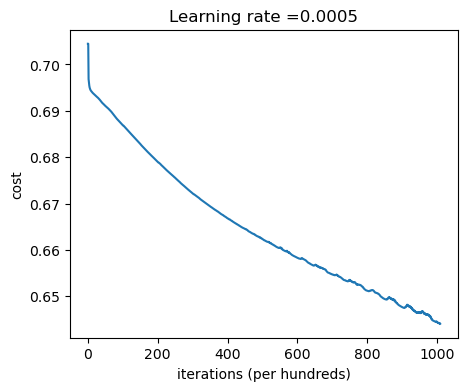

In [39]:
# Defincion de hyperparametros
samples = 6000
learning_rate = 0.0005
num_iterations = 1000

# 1 cargar los archivos con los datos de entranmeiento
base_dir = './Datasets/cats_vs_dogs/'
(X_train, y_train), (X_val, y_val), (X_test, y_test) = load_datesets(base_dir, samples, prepare=False)

print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de validación: {len(X_val)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")

X = X_train.T
Y = y_train.T

print(f"X.shape: {X.shape}, esto es: ejemplos={X.shape[1]}, características de cada ejemplo={X.shape[0]}")
print(f"Y.shape: {Y.shape}, esto es: etiquetas={Y.shape[1]}")

layer_dims = [X.shape[0], 30, 20, 10, 7, 5, 1]  # mdelo de X = , hidden_layers = 20, 7, 5, output_layer = 1

parameters, costs = training_model(X, Y, learning_rate, layer_dims, num_iterations, print_cost=True)
plot_costs(costs, learning_rate)

 
np.savez(os.path.join(base_dir, str(samples) + '_parameters') , **parameters)

X_input (150528, 1)
[[0.48502073]]
prediction 0
No es un perro.


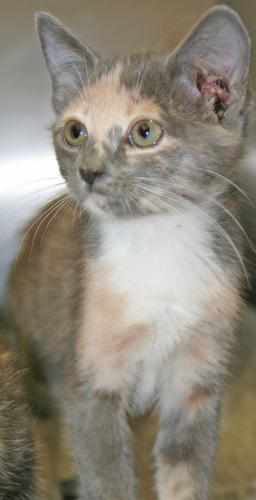

In [69]:
# Ruta a la imagen que quieres predecir
base_dir = './Datasets/cats_vs_dogs'
image_name = "353.jpg"

# Tamaño esperado por la red (ejemplo: 64x64 si ese es el tamaño que usaste en el entrenamiento)
#layer_dims = [X.shape[0], 30, 20, 10, 7, 5, 1]

# Preprocesar la imagen
image_path = os.path.join('./Datasets/cats_vs_dogs/no_dogs', image_name)
img_flat = load_and_preprocess_image(image_path, target_size = (224, 224))
X_input = np.array(img_flat)
X_input = np.resize(X_input, (X_input.shape[0], 1))
print("X_input", X_input.shape)

# Realizar la predicción
data = np.load(os.path.join(base_dir, '6000_30_20_10_7_5_1_dogs_parameters.npz'))
parameters = {key: data[key] for key in data}
prediction  = predict(X_input, parameters)

# Mostrar el resultado de la predicción
image = Image.open(image_path)
print("prediction", prediction[0][0])
if prediction  == 1:
    print("Es un perro.")
else:
    print("No es un perro.")

display(image)